# Рекомандательная система

## Загрузка библиотек

In [36]:
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import seaborn as sns
%matplotlib inline

## Загрузка данных

In [2]:
df_base = pd.read_csv("base.csv", index_col=0)
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [3]:
df_base.shape

(2918139, 72)

In [4]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


In [5]:
df_base.isna().sum().sort_values(ascending=False)

0     0
1     0
52    0
51    0
50    0
     ..
23    0
22    0
21    0
20    0
71    0
Length: 72, dtype: int64

In [6]:
df_base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.</br>
количество объектов: 2 918 139 </br>
количеств пропусков: 0

In [7]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [8]:
df_train = pd.read_csv("train.csv", index_col=0)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

In [10]:
df_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,...,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,...,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,...,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,...,-101.504830,19.774804,-178.929470,-71.745018,66.560655,-14.144571,31.685548,100.589324,-1074.464888,-76.478591
50%,-85.273695,7.652854,-42.830246,-146.067445,112.260100,-73.364420,-511.837758,22.278989,123.087540,125.963340,...,-80.859640,36.711365,-151.576985,14.072663,67.813585,23.441363,72.880192,115.236635,-808.801696,-48.700929
75%,-67.330810,10.981191,-17.713690,-132.277745,143.760830,-53.699612,-201.116578,65.899595,127.541802,169.701005,...,-60.492451,53.919520,-124.436974,100.011024,69.058750,59.941065,114.469224,129.791085,-357.087323,-20.487869
max,14.585236,28.917845,128.108460,-60.751625,301.363600,51.849710,109.625188,288.171840,149.356200,392.827150,...,47.733450,145.667130,11.907364,185.095137,74.779884,266.493320,319.867520,201.761260,98.768233,126.191790


In [11]:
df_train.isna().sum().sort_values(ascending=False)

0         0
37        0
53        0
52        0
51        0
         ..
24        0
23        0
22        0
21        0
Target    0
Length: 73, dtype: int64

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов). </br>
количество объектов: 100 000</br>
количество пропусков: 0

Посмотрим: как отличаются признаки в train и base

In [12]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

Относительное среднее разницы признаков

In [13]:
(((df_train.reset_index(drop=True)-df_base.loc[targets].reset_index(drop=True)).mean())/df_train.mean()).abs().sort_values(ascending=False)

65    0.038219
22    0.017438
16    0.016109
17    0.006861
30    0.005230
        ...   
66    0.000014
19    0.000012
3     0.000008
49    0.000007
29    0.000007
Length: 72, dtype: float64

Относительный разброс разницы признаков

In [14]:
(((df_train.reset_index(drop=True)-df_base.loc[targets].reset_index(drop=True)).std())/df_train.std()).abs().sort_values(ascending=False)

33    1.458398
59    1.413740
65    1.186457
21    1.160066
25    1.131906
        ...   
50    0.540020
46    0.539658
68    0.539455
56    0.539041
10    0.530266
Length: 72, dtype: float64

Максимальная относительное среднее разницы - 3.8%, при этом в большинстве признаков разница не превышает 1%. Относительный разброс максимум достигает 145%. Следовательно, в большинстве случаев, объекты, оцененные экспертами, как наиболее подходящие, действительно, находятся рядом с объектами train. Однако из-за разброса в некоторых случаях, возможно, данное заключение будет не выполняться.

## Обучение модели

### Поиск ближайших объектов

Удалим признаки, в которых объект из train и похожий на него объект из base сильно отличаются, так как при поиске ближайших соседей, мы можем исключить правильный ответ.

In [15]:
def drop_columns(columns):
    global df_base
    global df_train
    for c in columns:
        df_base = df_base.drop(c,axis=1)
        df_train = df_train.drop(c,axis=1)


In [16]:
drop_columns(['59','65','33','21'])

Подберем параметры: количество кластеров (n_cells) и количество рассматриваемых ближайших к объекту центроид (nprobe) для повышения качества первоначального отбора ближайших объектов.

In [23]:
dims = df_base.shape[1]
n_cells = 18000
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells,faiss.METRIC_L2)

In [18]:
idx_l2.nprobe = 800

In [19]:
scaler = StandardScaler()

scaler.fit(df_base)
df_base = pd.DataFrame(scaler.transform(df_base),columns=df_base.columns,index=df_base.index)
scaler.fit(df_train)
df_train = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns,index=df_train.index)


In [20]:
df_train.sum(axis=1)

Id
0-query        -0.067658
1-query         2.677433
2-query         4.112322
3-query        -1.253344
4-query        16.653447
                 ...    
99995-query    -2.948219
99996-query     8.606923
99997-query     7.168395
99998-query   -10.509321
99999-query     3.969141
Length: 100000, dtype: float64

In [24]:
idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))

idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [25]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 15)

In [26]:
false_targets = []
true_targets = []

In [27]:
acc = 0
index = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    t = int(target in [base_index[r] for r in el])
    if(t == 0):
        false_targets.append(index)
    else:
        true_targets.append(index)
    acc+=t
    index+=1

print(100 * acc / len(idx))

74.976


Точность при поиске ближайших 15 объектов: 74.976%</br>
Теперь обучим модель-классификатор для определения схожести объектов для перехода от 15 до 5 объектов.

In [25]:
df_train['cluster'] = idx_l2.assign(df_train,k=1)

In [38]:
tsne = TSNE(n_iter=1000)

In [39]:
df_visual = pd.DataFrame(tsne.fit_transform(df_train.drop('cluster',axis=1)))

In [40]:
df_visual.columns = ['x','y']

In [41]:
df_visual['cluster'] = df_train['cluster'].reset_index(drop=True)

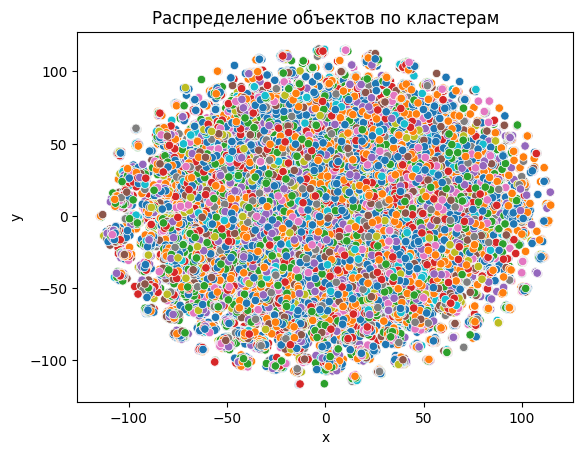

In [46]:
sns.scatterplot(data=df_visual,x='x',y='y',hue='cluster',legend=False,palette=sns.color_palette("tab10", as_cmap=True))\
.set(title='Распределение объектов по кластерам');

Посмотрим: почему правильные ответы не вошли в отобранные объекты

In [96]:
df_train_false = df_train.iloc[false_targets]

In [97]:
df_train_false

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
1-query,-0.094858,-0.173152,0.296912,-1.523962,0.189363,-0.370205,1.240223,-1.510417,0.284657,0.218924,...,-0.716320,1.314829,-1.270984,0.012808,0.202021,0.037262,0.266272,0.713549,-0.801388,-0.067236
6-query,-1.653556,0.405269,0.153122,0.230274,0.171283,-0.127849,1.523782,0.815333,0.877242,2.169375,...,-1.370210,1.489417,1.134898,0.163455,1.165700,-0.031531,0.051836,-1.392201,1.639056,0.800222
7-query,1.000706,0.059483,1.655172,0.152718,0.343546,-0.672645,1.065033,-0.159446,1.235188,-0.841574,...,1.030314,0.503721,0.487641,-1.257073,-0.276273,0.385941,-0.453810,1.626291,-0.898375,-0.425729
16-query,0.405688,-0.130156,0.642916,-0.586021,-0.639423,-1.321456,-0.739011,-0.090703,0.139326,0.031940,...,0.674219,0.622716,0.740328,-1.190659,0.406457,0.502856,-0.344320,0.479046,-0.898375,-0.563496
17-query,0.805602,-0.259336,1.700151,0.290121,0.133140,0.948139,0.977684,0.833534,-1.002194,-1.373114,...,-0.078473,-0.612169,1.263576,-1.955169,-0.444771,-0.028213,-0.668218,0.483374,-1.157677,-0.006381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99980-query,0.755011,0.679230,1.691373,-0.559819,-0.203234,-0.333202,1.621156,-1.484543,1.768640,0.257498,...,-0.542642,0.258179,-0.787314,0.278478,0.013669,0.810023,-0.326778,0.277705,-0.883912,0.298543
99989-query,-0.477443,0.409084,-1.521409,0.586007,0.710296,2.732397,0.700433,1.296842,0.830849,0.864719,...,-0.097863,-0.510198,-1.395976,0.721231,-0.797970,-0.867109,0.751972,0.753228,-0.898375,-0.210509
99995-query,0.664561,0.805785,-0.498907,-2.085072,0.405497,0.280425,-0.264005,1.132974,-0.663382,-2.029748,...,-0.990401,0.903762,0.066068,0.466502,-0.719379,-1.066838,-0.188453,-0.377709,-0.898375,0.324578


In [98]:
df_base_false = df_base.loc[targets.iloc[false_targets]]

In [99]:
((df_train_false.reset_index(drop=True)-df_base_false.reset_index(drop=True)).abs()).mean().sort_values(ascending=False)[:20]

62    0.803427
54    0.801530
26    0.792633
64    0.791569
18    0.791526
23    0.790077
51    0.788739
45    0.787492
32    0.786802
17    0.785682
7     0.785236
24    0.785172
39    0.783840
27    0.780666
52    0.779542
60    0.779112
11    0.777267
2     0.777209
57    0.775440
69    0.775432
dtype: float64

In [100]:
df_train_true = df_train.iloc[true_targets]

In [101]:
df_base_true = df_base.loc[targets[true_targets]]

In [102]:
((df_train_true.reset_index(drop=True)-df_base_true.reset_index(drop=True)).abs()).mean().sort_values(ascending=False)[:20]

6     0.499207
70    0.467358
25    0.452966
44    0.403327
42    0.235043
63    0.234049
17    0.225608
8     0.213434
32    0.210221
35    0.208909
36    0.208529
24    0.204057
1     0.201606
56    0.196033
30    0.195950
22    0.194071
62    0.193095
64    0.190741
47    0.190563
16    0.190206
dtype: float64

In [103]:
((df_train.reset_index(drop=True)-df_base.loc[targets].reset_index(drop=True)).abs()).mean().sort_values(ascending=False)

6     0.541576
70    0.530297
25    0.465283
44    0.443808
42    0.366124
        ...   
71    0.310754
28    0.309258
68    0.309182
67    0.309036
34    0.308236
Length: 68, dtype: float64

Среди правильно и неправильно распознанных объектах присутствуют признаки, значения в которых значительно отличаются между объектами из train и base: 59, 65, 33, 21. Следовательно, следует убрать такие признаки.

### Обучение классификатора

In [23]:
df_train['Target'] = targets

In [24]:
df_train_sample = df_train.sample(frac = 0.8,random_state=12345)

In [25]:
targets_sample = df_train_sample['Target']

In [26]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_sample.drop('Target',axis=1).values).astype('float32'), 15)

In [27]:
idx = idx.flatten()

In [28]:
df_base_sample = df_base.iloc[idx]

In [29]:
df_fin = pd.concat(df_train_sample.iloc[[i]*15] for i in range(len(df_train_sample))).reset_index(drop=True)

In [30]:
df_fin = df_fin.join(df_base_sample.reset_index(drop=True),lsuffix='_query',rsuffix='_base')

In [31]:
df_fin['base_index'] = df_base_sample.index

In [32]:
df_fin['Target'] = df_fin['Target'] == df_fin['base_index']

In [33]:
df_fin = df_fin.sample(frac=1)

In [34]:
df_fin['Target'].value_counts()

Target
False    1139940
True       60060
Name: count, dtype: int64

In [35]:
df_fin['Target'] = df_fin['Target'].astype('int32')

In [36]:
features_list = list(df_fin.columns)
target_name = 'Target'

features_list.remove('Target')
features_list.remove('base_index')

In [37]:
features = df_fin[features_list]
target = df_fin[target_name]

In [38]:
model = CatBoostClassifier(1_000)

In [39]:
model.fit(features,target)

Learning rate set to 0.212689
0:	learn: 0.4595448	total: 406ms	remaining: 6m 45s
1:	learn: 0.3383941	total: 650ms	remaining: 5m 24s
2:	learn: 0.2677777	total: 894ms	remaining: 4m 57s
3:	learn: 0.2266770	total: 1.14s	remaining: 4m 43s
4:	learn: 0.2061601	total: 1.39s	remaining: 4m 36s
5:	learn: 0.1925718	total: 1.65s	remaining: 4m 33s
6:	learn: 0.1851230	total: 1.88s	remaining: 4m 26s
7:	learn: 0.1808144	total: 2.13s	remaining: 4m 24s
8:	learn: 0.1732309	total: 2.37s	remaining: 4m 21s
9:	learn: 0.1713397	total: 2.6s	remaining: 4m 17s
10:	learn: 0.1688670	total: 2.85s	remaining: 4m 15s
11:	learn: 0.1648176	total: 3.08s	remaining: 4m 13s
12:	learn: 0.1639854	total: 3.34s	remaining: 4m 13s
13:	learn: 0.1610986	total: 3.57s	remaining: 4m 11s
14:	learn: 0.1589272	total: 3.8s	remaining: 4m 9s
15:	learn: 0.1551507	total: 4.06s	remaining: 4m 9s
16:	learn: 0.1544107	total: 4.32s	remaining: 4m 9s
17:	learn: 0.1515203	total: 4.6s	remaining: 4m 10s
18:	learn: 0.1495467	total: 4.88s	remaining: 4m 11

In [42]:
model = CatBoostClassifier.load_model(model,'model')

In [43]:
print(f1_score(target,model.predict(features)))

0.7978784322928889


In [44]:
del df_base_sample
del df_train_sample
del df_fin
del targets_sample
del features
del target

In [123]:
df_train = df_train.drop('Target',axis=1)

In [124]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 15)

In [125]:
idx = idx.flatten()

In [126]:
df_base_sample = df_base.iloc[idx]

In [127]:
df_train_sample = pd.concat(df_train.iloc[[i]*15] for i in range(len(df_train)))

In [128]:
df_fin = df_train_sample.reset_index(drop=True).join(df_base_sample.reset_index(drop=True),lsuffix='_query',rsuffix='_base')

In [129]:
df_fin['predict'] = model.predict_proba(df_fin)[:,1]

In [130]:
df_fin.index = df_train_sample.index

In [ ]:
df_fin['base_id'] = df_base_sample.index

In [66]:
def get_best(group):
    return group.sort_values(by='predict',ascending=False)[:5]['base_id'].values

In [8]:
out = df_fin.groupby(by='Id').apply(get_best)

In [9]:
acc = 0
for index,value in targets.items():
    t = int(value in out.loc[index])
    acc+=t

print(100 * acc / len(targets))

74.137


Точность после обучения модели составила: 74.137% при максимально возможной 74.976%.

## Тестирование

In [95]:
df_valid = pd.read_csv('validation.csv',index_col=0)

In [ ]:
df_valid.info()

In [ ]:
df_valid.describe()

In [ ]:
df_valid.isna().sum()

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv<br/>
количество объектов: 100 000<br/>
количество пропусков: 0

In [96]:
df_valid = df_valid.drop(['59','65','33','21'],axis=1)

Посмотрим: как отличаются датасеты train и validation

In [116]:
(df_valid.mean().reset_index(drop=True)-df_train.mean().reset_index(drop=True)).abs().sort_values(ascending=False)

19    1.180709e-14
52    8.028707e-15
28    4.164882e-15
54    3.914664e-15
8     2.429665e-15
          ...     
16    6.643575e-18
1     3.979039e-18
63    3.517187e-18
57    2.664535e-18
39    7.105427e-19
Length: 68, dtype: float64

In [117]:
(df_valid.std().reset_index(drop=True)-df_train.std().reset_index(drop=True)).abs().sort_values(ascending=False)

29    4.440892e-16
35    4.440892e-16
0     2.220446e-16
44    2.220446e-16
28    2.220446e-16
          ...     
20    0.000000e+00
21    0.000000e+00
27    0.000000e+00
26    0.000000e+00
34    0.000000e+00
Length: 68, dtype: float64

Распределение признаков в обоих датасетах одинаково.

In [97]:
targets = pd.read_csv('validation_answer.csv',index_col=0)

In [98]:
df_valid = pd.DataFrame(scaler.fit_transform(df_valid),columns=df_valid.columns,index=df_valid.index)

In [99]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_valid.values).astype('float32'), 15)

In [100]:
idx = idx.flatten()

In [101]:
df_base_sample = df_base.iloc[idx]

In [102]:
df_valid['Target'] = targets

In [103]:
df_valid_sample = pd.concat(df_valid.iloc[[i]*15] for i in range(len(df_valid)))

In [104]:
df_fin = df_valid_sample.reset_index(drop=True).join(df_base_sample.reset_index(drop=True),lsuffix='_query',rsuffix='_base')

In [105]:
df_fin['predict'] = model.predict_proba(df_fin.drop('Target',axis=1))[:,1]

In [106]:
df_fin['Id'] = df_valid_sample.index

In [107]:
df_fin['base_id'] = df_base_sample.index

In [108]:
out = df_fin.groupby(by='Id').apply(get_best)

In [109]:
targets = targets['Expected']

In [110]:
acc = 0
for index,value in targets.items():
    t = int(value in out.loc[index])
    acc+=t

print(100 * acc / len(targets))

73.106


Accuracy@5 на валидационной выборке: 73.106%

## Вывод

Алгоритм рекомендации товара:
1) Выбрать 15 ближайших по расстоянию объектов из base
2) Оценить отдельно каждый объект с помощью классификатора и выбрать 5 с наивысшим рейтингом.

Accuracy@5 на валидационной выборке: 73.106%

Рекомендации: использовать другие способы первоначального поиска: (пример) заменить евклидово расстояние на произведение координат, подобрать гиперпараметры для лучшей кластеризации